# Quantum zeno effect in a 2 level rabi system, stocahstically simulated using the Monte Carlo Wavefunction approach
In this notebook, we attempt to re-create the results of [1], in which the authors first ran a theoretical simulation using the density matrix approach to calculating the probability of our system existing in either an excited or unexcited state after a given time, while subject to regular measurements. After they had these preliminary results, acting as a theoretical bench mark, they moved on to using the Monte Carlo Wave Function approach to simualte the system in question.

We have recreated both of these.



In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

FONT_SIZE = 14 #font size for plots


## Density Matrix Approach

Our first task is to generate results using the density matrix approach. This approach invovles running a matrix of differential equations. This took a while to impliment, largely due to the fact that there were errors in the equations stated in [1]. After searching through their references, we managed to find [2]. The correct final set of equations describing our density matrix were:

$$\dot{P}_{cc} = - i \Omega_2 (P_{ca} - P_{ac}^*) - \gamma P_{cc}$$

$$\dot{P}_{ca} =   i \Omega_2 (P_{aa} - P_{cc}^*) - -i \Omega_1 P_{cb} - \gamma P_{ca}$$  
$$\dot{P}_{bb} = - i \Omega_1 (P_{ba} - P_{ba}^*)$$

$$\dot{P}_{ba} = - i \Omega_1 (P_{aa} - P_{bb}^*) - \Omega_2 P_{cb}^*$$

$$\dot{P}_{aa} = - (\dot{P}_{cc} + \dot{P}_{bb}) $$

$$\dot{P}_{cb} = - i \Omega_2 P_{ba}^* - i \Omega_1 P_{ca} - \frac{\gamma}{2} P_{ab}$$

Where these numbers represent a 3 energy level system, with energy levels a, b, and c. $\Omega_1$ represents the rabi frequency between 'a' and 'b', $\Omega_2$ represents the frequency between 'a' and 'c', and $\gamma$ represents the rate of sponatenous decay from state 'c' to 'a'.
A constant driving frequency is applied to the system, resulting in rabi oscillations between the ground state 'a', and the excited state 'b'. This means that, as long as we apply this driving frequency, any atoms in the system will be in a super position of being in the excited 'b' state, or the ground 'a' state. 
We then have a third state, 'c'. We can apply a frequency such that any atoms in the ground state will become exciting into the 'c' state, whos occupancy can be found by analysis of scattered flourercense. 

We expect, that after enough time, the probability of the states 'a' and 'b' to have a 50% each chance of being filled. The aim of this densitiy matrix approach, is to see how applying more frequent measurements can result in our system taking a longer time to reach this equilibrium point.

To apply a measurement, we apply a short frequency of $\Omega_2$, raising all those in state 'a' to jump to state 'c' for a short time, resulting in us being able to measure the occupancy of 'a', and so therefore 'b'. This means that, for the majority of the experiment, in our above equations $\Omega_0$. When we take a measurement, as well as setting $\Omega_2 \neq 0$, we also collapse our densitity matrix, taking only the diagonal.

### Implimentation of Density Matrix Approach

In [27]:
def calculate_P_dot(t, p_, gamma, omega_1, omega_2):
    """
    Iterates the set of equations defined in the text cell above, to find the 
    rate of change of our density matrix.

    Parameters
    ----------
    t : Float
        Current time step parameter, not used but required as part of using 
        scipy.solve_ivp
    p_ : Float array
        The value of our density matrix at this current time step. 
    gamma: float
        Spontanious decay rate from energy level c -> a
    omega_1: float
        Rabi frequency of states a->b
    omega_2: float
        Rabi frequency of states a->c
    
    returns
    --------
    dot_p: Float Array
        Matrix containing each P dot as described in the equations above.

    """
    #Define index of each energy level.
    a, b, c = 0,1,2

    #turn our previous iteration array to a 3x3 matrix for ease of calculation
    p = to_3x3(p_)
    dot_p = np.zeros((3,3), dtype=complex)

    #Calculate our density matrix rate of changes
    dot_cc = -1j * omega_2 * (p[c,a] - np.conj(p[c,a])) - gamma * p[c,c]
    dot_p[c,c] = dot_cc

   
    dot_ca = 1j * omega_2 * (p[a,a] - p[c,c]) - 1j * omega_1 * p[c,b] - gamma * p[c,a]
    dot_p[c,a] = dot_ca 

    dot_bb = -1j * omega_1 * (p[b,a] - np.conj(p[b,a]))
    dot_p[b,b] = dot_bb

    dot_ba= 1j * omega_1* (p[a,a] - p[b,b]) - 1j * omega_2 * np.conj(p[c,b])
    dot_p[b,a] = dot_ba

    dot_aa= -(dot_p[c,c]+dot_p[b,b])
    dot_p[a,a] = dot_aa

    dot_cb= 1j * omega_2*np.conj(p[b,a])  -1j*omega_1*p[c,a]- (gamma/2)*p[c,b]
    dot_p[c,b] = dot_cb

    #return a flat array to keep scipy happy
    return dot_p.flatten()

def remove1d_diag(flat):
    '''
    Takeas a flat 3x3 matrix (9 elements) and forms a flat matrix that contains
    only the diagonal elements of the initial matrix, with all other elements set to 0
    Represents the c
    '''
    return np.array([flat[0], 0,       0,
                     0,       flat[4], 0,
                     0,       0,       flat[8] ])

def to_3x3(flat):
    '''
    Takes a flat matrix and returns as a 3x3 matrix
    '''
    return np.array([[flat[0], flat[1], flat[2]],
                     [flat[3], flat[4], flat[5]],
                     [flat[6], flat[7], flat[8]]], dtype=complex)

In [28]:
def SimulateMeasurement(p0, t_max, dt_max, gamma, omega_1, omega_2, sig_delta, sig_len):
    '''
    Performs our experiment, using scipy.solve_ivp to calculate the evolution of
    our density matrix over time. When no measurement is taken, omega_2 is set to 0.
    For the duration of the calculation, we must routinely collapse our density 
    matrix to simulate measurement. This measurement lasts for a non-zero time, 
    during which we update the density matrix, with omega_2 as non 0.

    We continue this process of swapping between 'evolution' states, and 'measurement'
    states, until the desired total time has elapsed.
    We then return our results, which is the value of our density matrix at 
    each time step.

    Parameters
    ----------
    p0 : Float Array
        A 1d array of 9 elements representing a flattened initial density matrix.
    t_max : Float 
        The total time (in units of rabi frequency) to run the calculation
    dt_max : Float
        The maximum difference in time step between each value of our produced
        tiem dependent density matrix
    gamma : Float
        Rate of spontaneous decay from energy states 'c'->'a'
    omega_1 : Float
        Rabi frequency between energy states 'a'->'b'
    omega_2 : Float
        Rabi frequency between energy states 'a'->'c'
    sig_delta: Float
        Time (in units of rabi frequency) between each measurement. Time is measured
            between end of last measurement -> start of next measurement *
    sig_len : Float
        Time (in units of rabi frequency) that each measurement lasts. Time is measured
            from start of the measurement to end of the measurement *
    

    * This means that we make 1 measurement every (sig_delta + sig_len) rabi cycles.

    Returns
    --------
    final_sol : (Numpy) Array of Float Array (tx9)
        Array representing the values of our density matrix for each time step.
        The density matrix is stored in flat form 
    
    '''

    #Define the time arrays for the time between measurements, and the time of 
    #measurements
    time_sig_delta = np.linspace(0, sig_delta, int(sig_delta/dt_max))
    time_sig_len = np.linspace(0, sig_len, int(sig_len/dt_max))

    #create list to store all our data
    sol_y = []

    #Define the starting paramaters
    current_t = 0
    p_last = p0

    
    total_sol_len = 0    
    measure = False


    #Loop for whole simulation
    while(current_t < t_max):
        #create place holder for solution
        sol = None
        #If we currently wish to take a measurement
        if(measure):
            #We collapse our matrix
            p_last = remove1d_diag(p_last)
            #We define omega_2 to have a value
            args = (gamma, omega_1, omega_2,)
            #we run our calculation for the duration of measurement
            sol = solve_ivp(calculate_P_dot, [0, sig_len], p_last,  t_eval=time_sig_len, args=args, max_step = dt_max)
            #Once measurement is complete, we stop taking measurement for the next iteration
            measure = False
            #incriment time
            current_t += sig_len
            
        else: #if we are not taking a measurement

            #We collapse the matrix, as it should be in a collapsed state during (and at the end)
            #of measurement
            p_last = remove1d_diag(p_last)
            #If we are not currently measuring, we run the simulation with omega_2=0
            args = (gamma, omega_1, 0,)
            #solve
            sol = solve_ivp(calculate_P_dot, [0,sig_delta], p_last, t_eval=time_sig_delta, args=args, max_step = dt_max)
            #measure next iteration and incriment time
            measure = True
            current_t += sig_delta

        #Store all our results, 
        sol_y.append(sol.y.T)
        #define the next starting value, to be the final value of the density matrix
        #after the last iteration
        p_last = sol.y.T[-1]
        #incriment by the totl number of time steps
        total_sol_len += len(sol.y.T)

    #create array to store results
    final_sol = np.zeros((total_sol_len, 9), dtype=complex)
    i = 0
    #iterate through list of solutions, storing the result in a numpy array
    for element in sol_y:
        for matrix in element:
            final_sol[i] = np.array(matrix, dtype=complex)
            i+=1


    return final_sol

In [29]:
def CalculateProbForCustLenDelta(p0, t_max, dt_max, gamma, omega_1, omega_2, sig_len, sig_delta):
    '''
    Performs the experiment with the function 'SimulateMeasurement' with all defined
    parameters.
    We then extract the important information - the probability of occupation for 
    each quantum state - and store as an array, which we then return

    Parameters
    ----------
    p0 : Float Array
        A 1d array of 9 elements representing a flattened initial density matrix.
    t_max : Float 
        The total time (in units of rabi frequency) to run the calculation
    dt_max : Float
        The maximum difference in time step between each value of our produced
        tiem dependent density matrix
    gamma : Float
        Rate of spontaneous decay from energy states 'c'->'a'
    omega_1 : Float
        Rabi frequency between energy states 'a'->'b'
    omega_2 : Float
        Rabi frequency between energy states 'a'->'c'
    sig_delta: Float
        Time (in units of rabi frequency) between each measurement. Time is measured
            between end of last measurement -> start of next measurement *
    sig_len : Float
        Time (in units of rabi frequency) that each measurement lasts. Time is measured
            from start of the measurement to end of the measurement *
    

    * This means that we make 1 measurement every (sig_delta + sig_len) rabi cycles.

    Returns
    -------
        probs : Float array (tx3)
            An array representing the probability of energy state occupancy for each
            of our states, displayed over time.

            eg:
                probs[t, 0] - The probability that 'a' is occupied at time step t
                probs[t, 1] - The probability that 'b' is occupied at time step t
                probs[t, 2] - The probability that 'c' is occupied at time step t
    '''
    #if our delta is infinite, we take no measurements
    if(sig_delta == np.inf):
        sig_delta = t_max
    #run simulation
    sol = SimulateMeasurement(p0, t_max, dt_max, gamma, omega_1, omega_2, sig_delta, sig_len)

    #get probabilities
    probs = np.zeros((len(sol), 3))
    for i in range(len(sol)): 
        probs[i, 0] = np.sqrt(np.real(sol[i][0] * np.conj(sol[i][0])))
        probs[i, 1] = np.sqrt(np.real(sol[i][4] * np.conj(sol[i][4])))
        probs[i, 2] = np.sqrt(np.real(sol[i][8] * np.conj(sol[i][8])))

    return probs


In [30]:

def CalculateProbFor_n_measurements(p0, t_max, dt_max, gamma, omega_1, omega_2, n):
    '''
    Performs the experiment with the function 'SimulateMeasurement' with all defined
    parameters.
    We then extract the important information - the probability of occupation for 
    each quantum state - and store as an array, which we then return.

    Instead of requiring the signal delta and signal length, we simply require a
    variable 'n' defining the number of measurements to be taken each rabi cycle (a->b)
    The length of each measurement is then defined as a constant 20/gamma, and
    signal data defines as omega_1/n 

    Parameters
    ----------
    p0 : Float Array
        A 1d array of 9 elements representing a flattened initial density matrix.
    t_max : Float 
        The total time (in units of rabi frequency) to run the calculation
    dt_max : Float
        The maximum difference in time step between each value of our produced
        tiem dependent density matrix
    gamma : Float
        Rate of spontaneous decay from energy states 'c'->'a'
    omega_1 : Float
        Rabi frequency between energy states 'a'->'b'
    omega_2 : Float
        Rabi frequency between energy states 'a'->'c'
    sig_delta: Float
        Time (in units of rabi frequency) between each measurement. Time is measured
            between end of last measurement -> start of next measurement *
    sig_len : Float
        Time (in units of rabi frequency) that each measurement lasts. Time is measured
            from start of the measurement to end of the measurement *
    

    * This means that we make 1 measurement every (sig_delta + sig_len) rabi cycles.

    Returns
    -------
        probs : Float array (tx3)
            An array representing the probability of energy state occupancy for each
            of our states, displayed over time.

            eg:
                probs[t, 0] - The probability that 'a' is occupied at time step t
                probs[t, 1] - The probability that 'b' is occupied at time step t
                probs[t, 2] - The probability that 'c' is occupied at time step t

    '''

    #define signal length and delta
    sig_len = 20 * 1/gamma
    sig_delta = omega_1/n if n > 0 else t_max#1000 * sig_len

    #run simulation
    sol = SimulateMeasurement(p0, t_max, dt_max, gamma, omega_1, omega_2, sig_delta, sig_len)
    #calculate probabilities
    probs = np.zeros((len(sol), 3))
    for i in range(len(sol)): 
        probs[i, 0] = np.sqrt(np.real(sol[i][0] * np.conj(sol[i][0])))
        probs[i, 1] = np.sqrt(np.real(sol[i][4] * np.conj(sol[i][4])))
        probs[i, 2] = np.sqrt(np.real(sol[i][8] * np.conj(sol[i][8])))

    return probs

### Results of Density Matrix Approach
Now that we have all our code, we can run our simulations.
We decided to use the same parameters as the paper [1]. These require:
$$\Omega_1 = 2\pi$$
$$\Omega_2 = \gamma = 250\cdot \Omega_1$$
With our initial state having a 100% probability of being in the ground state 'a'.
We defined a set of measurement deltas to test, including 1 test where no measurements were taken. We then plot these together

In [31]:
p0 = np.array([[1,0,0],
               [0,0,0],
               [0,0,0]], dtype=complex).flatten()
t_max = 2
dt_max = 0.01

omega_1 = np.pi * 2
gamma =250 * omega_1
omega_2 = gamma

measure_deltas = [np.inf, 0.2, 0.1, 0.04]
results = []
for delta in measure_deltas:
    d = delta
    if d != np.inf:
        d = delta/2
    results.append(CalculateProbForCustLenDelta(p0, t_max, dt_max, gamma, omega_1, omega_2, 0.01, d)[:,1])


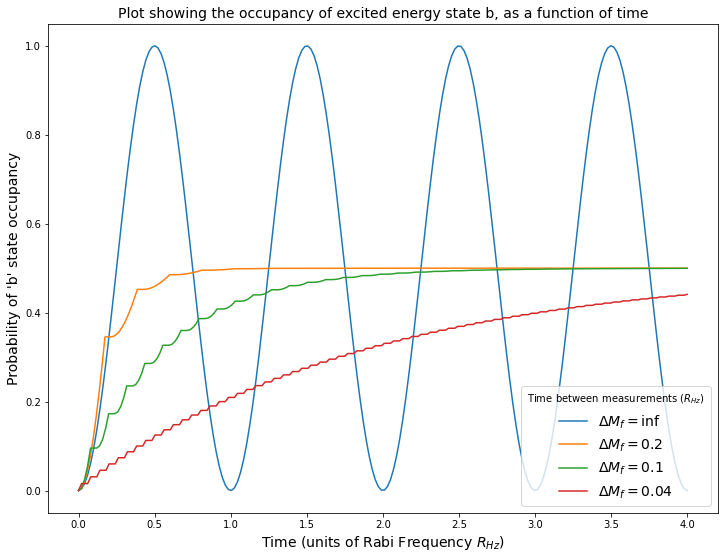

In [32]:

fig = plt.figure(figsize=(12,9))
ax = fig.subplots()
ax.set_title("Plot showing the occupancy of excited energy state b, as a function of time", fontsize=FONT_SIZE)
for i, res in enumerate(results):
    time = np.linspace(0, t_max, len(res)) / 0.5
    ax.plot(time, res, label=r"$\Delta M_f=$" + str(measure_deltas[i]))

ax.legend(title=r"Time between measurements ($R_{Hz}$)", loc='lower right', fontsize=FONT_SIZE)
ax.set_ylabel("Probability of 'b' state occupancy", fontsize=FONT_SIZE)
ax.set_xlabel(r"Time (units of Rabi Frequency $R_{Hz}$)", fontsize=FONT_SIZE)

plt.savefig("density_matr_approach.png")
plt.savefig("density_matr_approach.pdf")

plt.show()


For this result, we see that when no measurement is taken, our system quickly tends towards a super position where the state isn't known, with each energy level having an equal 50-50 chance of being occupied.

For our results where measurements are taken, we see a clear result. The more frequently that measurement are taken, the longer it takes for our system to evolve into its equilibrium state. 

$\Delta$Measure $=0.2$ represents the same value chosen by our examined paper. We improved on their result by showing how the effect of more frequent measurements resulted in a longer time to reach an equilibirum state.

## Monte Carlo Wave Function
The monte carlo wave function approach (MCWF) works by performing quantum jumps:
a probability at each time step that a system changes quantum states is calculated. This is then compared to a random number. If it falls within the correct bounds, we apply the jump.
From [3] we get the following algorithm:

1.   From an initial state $|\psi_\alpha(t)\rangle$ compute the probability of no jump, $p_0$:
    $$
     p_0 = 1 - \delta t \sum_k \langle\psi_a|\hat{L}^\dagger_k\hat{L}_k|\psi_a\rangle 
     $$
    and the probabilities $p_k$ associated with the jump operator $\hat{L}_k$:
    $$
    p_k = \delta t \langle\psi_a|\hat{L}^\dagger_k\hat{L}_k|\psi_a\rangle 
    $$
2.   Determine if a jump will occur. If it does occur, randomly choose a jump operator $\hat{L}_k$. We do this by generating a random number $r \in [0,1]$, if $r<p_{0}$, then no jump occurs and the system evolves via $\hat{H}_{eff}$. Otherwise, we choose the jump operator $\hat{L}_k$ such that we choose the smallest k=n that satisfies:
    $$\sum_{k=0}^n p_k > r$$
3.   If no jump occurs, compute the infinitesmial evolution generated by $\hat{H}_{eff}$, and renormalise with $p_0$.
4.   If a jump does occur, calculate the new state $|\psi_a(t+\delta t)\rangle$ and normalise with $p_k$:
    $$|\psi_a^k\rangle = \sqrt{\frac{\delta t}{p_k}}\hat{L}_k |\psi_a\rangle$$


### Implimentation of MCWF

We also used some code [4] already written to impliment the MCWF. This didn't quite go to the full extent that we desired, not inlcuding our jumper operators. We were able to use this code as a starting point, and combined with the equations listed above, we were able to get our MCWF approach working.


In [10]:
#Various matricies we need for our simulation.

Sp = np.array([[0, 0],
               [1,0]], dtype=complex)
Sm = np.array([[0, 1],
               [0,0]], dtype=complex)
Ee = np.array([[0, 0],
               [0,1]], dtype=complex) #Sigma+ * Sigma-
Ve = np.array([[0, 1],
               [1,0]], dtype=complex) #Sigma+ + Sigma-
Id = np.array([[1, 0],
               [0,1]], dtype=complex)

a_dag = np.array([[0, 0],
                  [1,0]], dtype=complex)
a     = np.array([[0, 1],
                  [0, 0]], dtype=complex)

a_dag_minus_a = np.array([[0, -1],
                          [1,  0]], dtype=complex)
a_dag_mult_a =  np.array([[0, 0],
                          [0,1]], dtype=complex)

N = 2
#Define a complex number properly, because we aren't engineers
I = 1j



class Rabi_MCWF:
    '''
    A class that allows for simulating of a 2 level rabi system, with measurements
    taken at set intervals.
    To use, first initialise with system variables
    Then use run_experiment, while specifiying various experiment parameters

    Attributes
    ----------
    hbar: float
        The value for hbar that should be used. No default is set, but keeping
        it as unity will imporve algorithm speed
    n_th: float != 0
        A unit used in defining the magnitude of our jump operators, the exact origin
        of this valeu is not known. 
    kappa: float
        A unit used in defining the magnitude of our jump operators. Optimum to have
        time scale set such that kappa=1
    eta: float
        The rabi frequency of the system
    ham: complex matrix (2x2 numpy array)
        Matrix representing the hamiltonian of the system
    ham_nh: complex matrix (2x2 numpy array)
        Matrix representing the non hermitian hamiltonian for the system,
        the effective hamiltonian when modified by our jump operators
    jump_operators: list of 2 compelx matrix (2x2 numpy array)
        The two jump operators for this system
    '''
    def __init__(self, hbar, n_th, kappa, eta):
        '''
        Constructor for this MCWF system. Defines our hamiltonians, and our
        jump operators.

        Parameters
        ----------
        hbar: float
            The value for hbar that should be used. No default is set, but keeping
            it as unity will imporve algorithm speed
        n_th: float != 0
            A unit used in defining the magnitude of our jump operators, the exact origin
            of this valeu is not known. 
        kappa: float
            A unit used in defining the magnitude of our jump operators. Optimum to have
            time scale set such that kappa=1
        eta: float
            The rabi frequency of the system
        '''
        self.hbar = hbar
        self.n_th = n_th
        self.kappa = kappa
        self.eta = eta
        self.ham = self.GenerateHamiltonian()
        self.jump_operators = self.GenerateJumpOperators()
        self.ham_nh = self.GenerateNonHermHamiltonian()

    def GenerateHamiltonian(self):
        '''
        Generates the hamiltonian for this system 
        '''
        ham = I * self.eta * a_dag_minus_a
        return ham

    def GenerateJumpOperators(self):
        return [np.matrix(np.sqrt(2 * self.kappa * (self.n_th)) * a), 
                np.matrix(np.sqrt(2 * self.kappa * (self.n_th+1)) * a_dag)]
                
    def GenerateNonHermHamiltonian(self):
        jump_part = np.zeros((2,2), dtype=complex)
        for i in range(2):
            jump_part += np.dot(self.jump_operators[i].H, self.jump_operators[i])

        return self.ham - 0.5 * I * self.hbar * jump_part
    def normalize(self, phi):
        """
        Simple function for normalizing phi, as numpy cannot normalize complex vectors
        """
        norm = 0
        for i in range(2):
            norm += np.real(np.conj(phi[i]) * phi[i])
        norm = np.sqrt(norm)
        phi/= norm

    
    def noJump(self, dt, dp, it, phi):
        #ham_nh = GenerateNonHermitianHamiltonian(ham)

        #Equation (2b)
        phi[it] = np.dot((Id - (I * dt/ self.hbar) * self.ham_nh ), phi[it-1]) / np.sqrt(1-dp)
        
    def jump(self, dt, p_k, jump_op, it, phi):
        phi[it] = np.sqrt(dt/p_k) * (jump_op @ phi[it-1])


    def calcP_k(self, phi):
        '''
        Calculates all probabilities: p_k for each of our jump operators J_k
        
        Parameters
        ----------
        '''
        results = np.zeros((2))
        for k in range(2):

            p_k = np.real(np.conj(phi) @  self.jump_operators[k].H @ self.jump_operators[k] @ phi)
            #The matrix product above results in a 1*1 numpy array, we must extract this to a float
            results[k]=(p_k[0,0])

        return np.flip(results)

    def propagate_single_traj(self, dt,n_total, phi, measure_it, measure_steps):
        '''
        Propagates the entire trajectory for a single quantum system
        '''
        phi[0,0] = 1
        phi[0,1] = 0
        last_delta = 0

        for it in range(1, n_total):
            #print(phi[it-1])
            #Generate the probability of a jump occuring.
            #A jump is more likely when dp is minimized
            #dp is smallest when the |phi| is small
            #print(phi, phi[it-1])
            p_k_all = dt * self.calcP_k(phi[it-1])
            dp = np.sum(p_k_all)
            epsilon = np.random.rand()

            #print(dp, epsilon, dp>epsilon)


            #print(p_k_all)
            measure = False
            if(it -  last_delta > measure_it):
                measure = True
                if(it - last_delta > measure_it + measure_steps):
                    last_delta = it
                    measure = False
            if(measure):
                p_current = 0

                r = np.random.rand()
                p_k_all/=dp
                fin=False
                for i in range(2):
                    if(fin):
                        continue
                    p_k =p_k_all[i]
                    p_current +=p_k

                    if(p_current > r):
                        self.jump(dt, p_k, self.jump_operators[i], it, phi)
                        #print(phi[it-1], p_k_all, r, "jump:" , i)

                        self.normalize(phi[it])
                        #print("jump: ", i)
                        break
            #Rather that performing out jumps in a random way,
            #we run no jump during a time of no measurement
            else:
                self.noJump(dt, dp, it, phi)
                self.normalize(phi[it])

    def run_experiment(self, n_total, measure_delta, measure_length, dt, iterations):
        all_phi = np.zeros((iterations, n_total, 2), dtype=complex)
        phi = np.zeros((n_total, 2), dtype=complex)
        population = np.zeros((n_total, 2))

        #re run the simulation for ns times, taking the average
        for is_ in tqdm(range(iterations)):
            self.propagate_single_traj(dt,n_total, phi, measure_delta, measure_length)
            all_phi[is_] = phi
            for it in range(n_total):
                for i in range(2):
                    population[it,i] += np.real(np.conj(phi[it,i]) * phi[it, i])/(1*iterations)
        return population, all_phi


We have now created a holder class for our simulation, helping keep all variables organised. We have also defined out x axis, such that 1 represents 1 rabi period.
We currently are simulating 2000 data points. This means that 1 rabi frequency represents 500 data points. In our density matrix approach, we defined our measurement frequencies as fractions of this value.
We can now do this again, to try and recreate the same results.

### Results of MCWF approach

In [13]:
#we define starting parameters for our system, with time ranging for 4 rabi cycles
mcfw_sim = Rabi_MCWF(1,10,1,np.pi*2)

#We define our total time
exp_time_steps = 2000
it_per_rabi = int(exp_time_steps * 0.25) # 500 time steps per rabi
dt = .001

#number of times to run each simulation, from which we take an average
exp_iterations=1000


#We define our measurement frequencies as a fraction of our rabi period
measure_deltas = [np.inf, 0.2, 0.1, 0.04]
results = []

for delta in measure_deltas:

    measure_freq = int(delta * it_per_rabi) if (delta != np.inf) else delta

    #for our in
    iterations = 1 if delta == np.inf else exp_iterations
    print("Running {0} iterations for freq = {1}".format(iterations, measure_freq))
    sol, phi = mcfw_sim.run_experiment(2000, measure_freq, 1, dt, iterations)
    results.append(sol[:,1])
    


Running 1 iterations for freq = inf



Running 1000 iterations for freq = 100



Running 1000 iterations for freq = 50



Running 1000 iterations for freq = 20


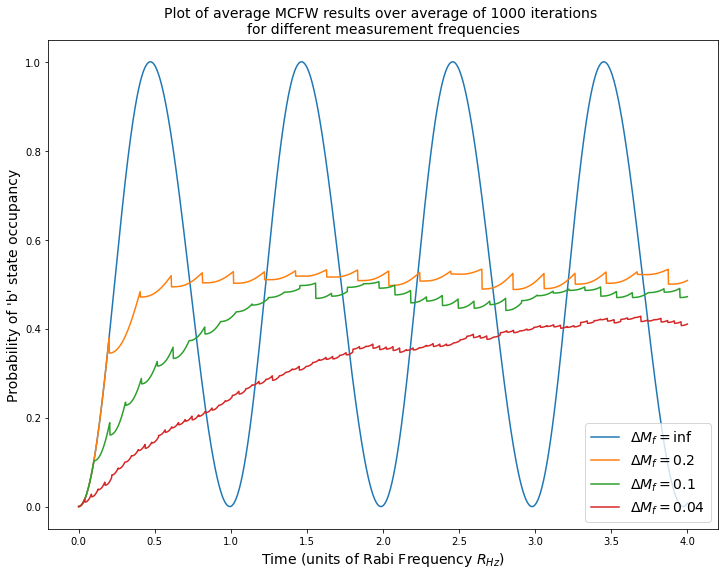

In [14]:
fig = plt.figure(figsize=(12,9))
ax = fig.subplots()


time = np.linspace(0, 4, 2000)
ax.set_title("Plot of average MCFW results over average of {0} iterations \nfor different measurement frequencies".format(exp_iterations), fontsize=FONT_SIZE)

for delta, res in zip(measure_deltas, results):
    plt.plot(time, res, label=r"$\Delta M_f=$" + str(delta))
ax.set_ylabel("Probability of 'b' state occupancy", fontsize=FONT_SIZE)
ax.set_xlabel(r"Time (units of Rabi Frequency $R_{Hz}$)", fontsize=FONT_SIZE)
plt.legend(loc='lower right',  fontsize=FONT_SIZE)

plt.savefig("MCFW_results.pdf")

plt.show()


The results from this test seem to show our results tending towards the expected values, something we see if we compare to our first figure. However, computational limits of using python mean we cannot run these tests for enough iterations to get good results. 
Because of this, we re-wrote our MCWF algorithm in C++. This allowed us to run more tests, and for many more iterations. This also meant we were able to increasee the measurement frequency. Due to our limitations for the density matrix approach, we cannot get accurate results for high frequency measurements, and so this C++ code allows us to see further into this effect.

<img src="density_matr_approach.png" style="width: 850px">
<img src="Cpp/RabiCpp/mcfw_high_it_results.png" style="width: 850px">

Our results are clear. From this computational method of simulating the behaviour of our quantum state, we see a clear example of the quantum zeno effect taking place. Our highest frequency test had a measurement every $0.0004$ cycles, close to our computational minimum. We see that with the measurement frequency, there is almost no evolution of our quantum state.

# References

[1] W. L. Power and P. L. Knight, *Stochastic simulations of the quantum Zeno effect*, Phys. Rev. A53, 1052 (1996).

[2] V. Frerichs and A. Schenzle, *Quantum Zeno effect without collapse of the wave packet*, Phys. Rev. A 44, (1991)

[3] M. Kornyik and A. Vukics, *The Monte Carlo wave-function method: A robust adaptive algorithm and a study in convergence*, Computer Physics Communications Vol 238, (2019)

[4] https://github.com/timy/mcwf